In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Then import the module directly
from src.data_preprocessing import PetDataset

# Set random seed for reproducibility
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Using device: cpu


In [2]:
class PointPromptedPetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, point_sample_mode='foreground_weighted'):
        """
        Enhanced dataset class that adds point prompts for segmentation.
        
        Args:
            root_dir (string): Directory with the dataset.
            split (string): 'train', 'val' or 'test' split.
            transform (callable, optional): Transform to be applied on the input image and mask.
            point_sample_mode (string): Strategy for sampling points:
                - 'foreground_weighted': Sample from foreground with higher probability
                - 'random': Completely random point
                - 'class_balanced': Balance points across classes
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.point_sample_mode = point_sample_mode
        
        # Set paths for images and masks
        self.image_dir = os.path.join(root_dir, split, 'color')
        self.mask_dir = os.path.join(root_dir, split, 'label')
        
        # Get all image file names
        if os.path.exists(self.image_dir):
            self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                      if os.path.isfile(os.path.join(self.image_dir, f))])
        else:
            print(f"Warning: Image directory {self.image_dir} does not exist")
            self.image_files = []
        
    def __len__(self):
        return len(self.image_files)
    
    def _sample_point(self, mask):
        """Sample a point based on the defined strategy.
        
        Args:
            mask: Numpy array of shape (H, W) with class indices
            
        Returns:
            tuple: (y, x) coordinates of the sampled point
        """
        h, w = mask.shape
        valid_mask = mask != 255  # Exclude ignore regions
        
        if self.point_sample_mode == 'random':
            # Completely random point (avoids ignore regions)
            valid_points = np.where(valid_mask)
            if len(valid_points[0]) > 0:
                idx = np.random.randint(0, len(valid_points[0]))
                return (valid_points[0][idx], valid_points[1][idx])
            else:
                return (h // 2, w // 2)  # Fallback to center
                
        elif self.point_sample_mode == 'foreground_weighted':
            # Sample with higher probability from foreground classes
            # Weight: background=1, cat=5, dog=5
            weights = np.ones_like(mask, dtype=np.float32)
            weights[mask == 1] = 5.0  # Cat class
            weights[mask == 2] = 5.0  # Dog class
            weights[mask == 255] = 0.0  # Ignore regions
            
            weights = weights / weights.sum()  # Normalize to probability distribution
            flat_idx = np.random.choice(h * w, p=weights.flatten())
            y, x = flat_idx // w, flat_idx % w
            return (y, x)
            
        elif self.point_sample_mode == 'class_balanced':
            # Sample one point per class with equal probability
            classes = np.unique(mask)
            classes = classes[classes != 255]  # Remove ignore index
            selected_class = np.random.choice(classes)
            
            class_points = np.where(mask == selected_class)
            if len(class_points[0]) > 0:
                idx = np.random.randint(0, len(class_points[0]))
                return (class_points[0][idx], class_points[1][idx])
            else:
                return (h // 2, w // 2)  # Fallback to center
        
        else:
            raise ValueError(f"Unknown point_sample_mode: {self.point_sample_mode}")
    
    def _create_point_heatmap(self, point, shape, sigma=3.0):
        """Create a Gaussian heatmap around the selected point.
        
        Args:
            point: (y, x) coordinates of the point
            shape: Output shape (H, W)
            sigma: Standard deviation of Gaussian kernel
            
        Returns:
            torch.Tensor: Heatmap of shape (1, H, W)
        """
        y, x = point
        h, w = shape
        
        # Create coordinate grids
        y_grid, x_grid = torch.meshgrid(
            torch.arange(0, h, dtype=torch.float32),
            torch.arange(0, w, dtype=torch.float32),
            indexing='ij'
        )
        
        # Calculate squared distances
        squared_dist = (y_grid - y) ** 2 + (x_grid - x) ** 2
        
        # Create Gaussian heatmap
        heatmap = torch.exp(-squared_dist / (2 * sigma ** 2))
        
        # Normalize to [0, 1]
        heatmap = heatmap / heatmap.max()
        
        # Add channel dimension
        return heatmap.unsqueeze(0)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Get corresponding mask file
        mask_name = img_name.replace('.jpg', '.png')
        if not os.path.exists(os.path.join(self.mask_dir, mask_name)):
            # Try with other extensions if needed
            mask_name = img_name.split('.')[0] + '.png'
            
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        
        # Load and process mask
        mask = Image.open(mask_path).convert('RGB')
        mask_np = np.array(mask)
        
        # Convert RGB mask to class indices
        seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        
        # Background (black)
        black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[black_mask] = 0
        # Cat (red)
        red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[red_mask] = 1
        # Dog (green)
        green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
        seg_mask[green_mask] = 2
        # White border (ignore)
        white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
        seg_mask[white_mask] = 255  # Use 255 as ignore index
        
        # Create a PIL Image from the segmentation mask
        seg_mask_pil = Image.fromarray(seg_mask)
        
        # Apply joint transformations
        if self.transform:
            image_transformed, seg_mask_transformed = self.transform(image, seg_mask_pil)
            
            # Sample a point after transformations
            seg_mask_np = np.array(seg_mask_transformed)
            sampled_point = self._sample_point(seg_mask_np)
            
            # Create point heatmap
            point_heatmap = self._create_point_heatmap(
                sampled_point, 
                shape=(image_transformed.shape[1], image_transformed.shape[2])
            )
            
            # The class at the sampled point
            point_class = seg_mask_np[sampled_point[0], sampled_point[1]]
            
            return image_transformed, point_heatmap, seg_mask_transformed, sampled_point, point_class
        else:
            # Convert to tensor if no transform
            image = TF.resize(image, (224, 224))
            seg_mask_pil = TF.resize(seg_mask_pil, (224, 224), interpolation=TF.InterpolationMode.NEAREST)
            
            image_tensor = TF.to_tensor(image)
            seg_mask_array = np.array(seg_mask_pil)
            seg_mask_tensor = torch.from_numpy(seg_mask_array).long()
            
            # Sample a point
            sampled_point = self._sample_point(seg_mask_array)
            
            # Create point heatmap
            point_heatmap = self._create_point_heatmap(
                sampled_point, 
                shape=(image_tensor.shape[1], image_tensor.shape[2])
            )
            
            # The class at the sampled point
            point_class = seg_mask_array[sampled_point[0], sampled_point[1]]
            
            return image_tensor, point_heatmap, seg_mask_tensor, sampled_point, point_class

In [3]:
# Set paths and create datasets
data_root = "../Dataset_augmented/"

# Create datasets - directly use train/val/test splits from the augmented dataset
train_dataset = PointPromptedPetDataset(data_root, 'train')
val_dataset = PointPromptedPetDataset(data_root, 'val')
test_dataset = PointPromptedPetDataset(data_root, 'test')

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Checking dataset contents...")
train_dir = os.path.join(data_root, 'train', 'color')
print(f"Train image count: {len(os.listdir(train_dir))}")
print(f"Checking first few images...")
for i, f in enumerate(os.listdir(train_dir)[:5]):
    path = os.path.join(train_dir, f)
    size = os.path.getsize(path) / (1024*1024)  # Size in MB
    print(f"  {f}: {size:.2f} MB")

# Create dataloaders
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Training set size: 11776
Validation set size: 736
Test set size: 3710
Checking dataset contents...
Train image count: 11776
Checking first few images...
  Persian_188_aug1.jpg: 0.01 MB
  leonberger_143_aug2.jpg: 0.01 MB
  Sphynx_151_aug0.jpg: 0.01 MB
  Birman_100_aug0.jpg: 0.01 MB
  Abyssinian_142_aug0.jpg: 0.01 MB


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
class PointPromptedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features_start=32, point_encoder_type='concat'):
        """
        UNet model modified to incorporate point prompts.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output classes
            features_start (int): Number of features in first layer
            point_encoder_type (str): How to incorporate point features:
                - 'concat': Concatenate point heatmap with image in input
                - 'parallel': Process point heatmap in parallel branch and concatenate features
        """
        super(PointPromptedUNet, self).__init__()
        
        self.point_encoder_type = point_encoder_type
        
        # Adjust input channels to include point heatmap for 'concat' approach
        if point_encoder_type == 'concat':
            adjusted_in_channels = in_channels + 1  # +1 for point heatmap channel
        else:  # 'parallel' approach
            adjusted_in_channels = in_channels
        
        # Encoder (Downsampling) for image
        self.encoder1 = DoubleConv(adjusted_in_channels, features_start)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features_start, features_start*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(features_start*2, features_start*4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(features_start*4, features_start*8)
        self.pool4 = nn.MaxPool2d(2)
        
        # Point encoder branch for 'parallel' approach
        if point_encoder_type == 'parallel':
            self.point_encoder1 = DoubleConv(1, features_start // 2)
            self.point_pool1 = nn.MaxPool2d(2)
            self.point_encoder2 = DoubleConv(features_start // 2, features_start)
            self.point_pool2 = nn.MaxPool2d(2)
            self.point_encoder3 = DoubleConv(features_start, features_start*2)
            self.point_pool3 = nn.MaxPool2d(2)
            self.point_encoder4 = DoubleConv(features_start*2, features_start*4)
            self.point_pool4 = nn.MaxPool2d(2)
            
            # Feature fusion at bottom
            self.bottom = DoubleConv(features_start*8 + features_start*4, features_start*16)
        else:
            # Standard bottom for 'concat' approach
            self.bottom = DoubleConv(features_start*8, features_start*16)
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features_start*16, features_start*8)
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features_start*8, features_start*4)
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features_start*4, features_start*2)
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features_start*2, features_start)
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)

    def forward(self, x, point_heatmap):
        # Concatenate image and point heatmap for 'concat' approach
        if self.point_encoder_type == 'concat':
            x = torch.cat([x, point_heatmap], dim=1)
            
            # Encoder
            enc1 = self.encoder1(x)
            enc2 = self.encoder2(self.pool1(enc1))
            enc3 = self.encoder3(self.pool2(enc2))
            enc4 = self.encoder4(self.pool3(enc3))
            
            # Bottom
            bottom = self.bottom(self.pool4(enc4))
            
        else:  # 'parallel' approach
            # Image encoder branch 
            enc1 = self.encoder1(x)
            enc2 = self.encoder2(self.pool1(enc1))
            enc3 = self.encoder3(self.pool2(enc2))
            enc4 = self.encoder4(self.pool3(enc3))
            img_features = self.pool4(enc4)
            
            # Point encoder branch
            p_enc1 = self.point_encoder1(point_heatmap)
            p_enc2 = self.point_encoder2(self.point_pool1(p_enc1))
            p_enc3 = self.point_encoder3(self.point_pool2(p_enc2))
            p_enc4 = self.point_encoder4(self.point_pool3(p_enc3))
            point_features = self.point_pool4(p_enc4)
            
            # Concatenate features at bottom
            combined_features = torch.cat([img_features, point_features], dim=1)
            bottom = self.bottom(combined_features)
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [6]:
def train_point_prompted_unet(model, train_loader, val_loader, num_epochs=50, cat_weight=2.1, device=device):
    """
    Train the Point-Prompted U-Net model.
    
    Args:
        model: Point-Prompted U-Net model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        cat_weight: Weight for the cat class
        device: Device to train on
        
    Returns:
        Trained model
    """
    # Add these lines at the beginning
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    accumulation_steps = 2
    
    print("Function started: train_point_prompted_unet")
    start_time = time.time()
    
    # Define class weights to address class imbalance [background, cat, dog]
    print("Setting up class weights...")
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)
    print(f"Class weights created: {time.time() - start_time:.2f}s")

    # Define loss function with class weights and ignore_index for white pixels
    print("Setting up criterion...")
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    print(f"Criterion created: {time.time() - start_time:.2f}s")
    
    # Define optimizer
    print("Setting up optimizer...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Optimizer created: {time.time() - start_time:.2f}s")
    
    # Test data loading
    print("Testing data loading...")
    try:
        test_imgs, test_points, test_masks, _, _ = next(iter(train_loader))
        print(f"Sample batch loaded - images: {test_imgs.shape}, points: {test_points.shape}, masks: {test_masks.shape}")
        print(f"Data loading test: {time.time() - start_time:.2f}s")
        
        # Test batch to GPU transfer
        print("Testing batch GPU transfer...")
        test_imgs = test_imgs.to(device)
        test_points = test_points.to(device)
        test_masks = test_masks.to(device)
        print(f"GPU transfer test: {time.time() - start_time:.2f}s")
        
        # Test forward pass
        print("Testing forward pass...")
        with torch.no_grad():
            test_output = model(test_imgs, test_points)
        print(f"Forward pass test: {time.time() - start_time:.2f}s")
    except Exception as e:
        print(f"Error in data loading test: {e}")
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []
    train_dice = []
    val_dice = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    # Create figures for live plotting
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # GPU memory tracking
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            mem_allocated_start = torch.cuda.memory_allocated() / 1e9
        
        # Training phase
        model.train()
        running_loss = 0.0
        intersection = torch.zeros(3, device=device)
        union = torch.zeros(3, device=device)
        dice_intersection = torch.zeros(3, device=device)
        dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=True)
        
        # Reset gradients at the start of each epoch
        optimizer.zero_grad()
        batch_count = 0
        
        for images, point_heatmaps, masks, _, _ in train_pbar:
            batch_count += 1
            # Move data to device
            images = images.to(device)
            point_heatmaps = point_heatmaps.to(device)
            masks = masks.to(device)
            
            # Forward pass with mixed precision
            with autocast():
                outputs = model(images, point_heatmaps)
                loss = criterion(outputs, masks)
            
            # Scale loss by accumulation steps and backward pass
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()
            
            # Update weights after accumulation_steps
            if batch_count % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            # Track loss (use the original loss value for tracking)
            running_loss += (loss.item() * accumulation_steps) * images.size(0)
            
            # Calculate metrics (use non-scaled outputs)
            with torch.no_grad():
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU and Dice metrics
                for cls in range(3):
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    intersection[cls] += (pred_cls & true_cls).sum().float()
                    union[cls] += (pred_cls | true_cls).sum().float()
                    
                    dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
            
            # Update progress bar
            train_pbar.set_postfix(loss=loss.item() * accumulation_steps)
        
        # Make sure to update for any remaining batches (if dataset size % accumulation_steps != 0)
        if batch_count % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Calculate average training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Calculate IoU
        class_ious = []
        for cls in range(3):
            iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
            class_ious.append(iou.item())
        mean_iou = sum(class_ious) / len(class_ious)
        train_iou.append(mean_iou)
        
        # Calculate Dice coefficient
        class_dice = []
        for cls in range(3):
            dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
            class_dice.append(dice.item())
        mean_dice = sum(class_dice) / len(class_dice)
        train_dice.append(mean_dice)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = torch.zeros(3, device=device)
        val_union = torch.zeros(3, device=device)
        val_dice_intersection = torch.zeros(3, device=device)
        val_dice_sum = torch.zeros(3, device=device)
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False)
        
        with torch.no_grad():
            for images, point_heatmaps, masks, _, _ in val_pbar:
                # Move data to device
                images = images.to(device)
                point_heatmaps = point_heatmaps.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images, point_heatmaps)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
                
                # Calculate metrics
                _, predicted = torch.max(outputs, 1)
                mask = (masks != 255)
                
                # Calculate IoU
                for cls in range(3):  # 3 classes: background, cat, dog
                    pred_cls = (predicted == cls) & mask
                    true_cls = (masks == cls) & mask
                    
                    # Intersection and union
                    val_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_union[cls] += (pred_cls | true_cls).sum().float()
                    
                    # Dice coefficient
                    val_dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                    val_dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
                
                # Update progress bar
                val_pbar.set_postfix(loss=loss.item())
        
        # Calculate average validation metrics
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Calculate IoU
        val_class_ious = []
        for cls in range(3):
            iou = val_intersection[cls] / val_union[cls] if val_union[cls] > 0 else 0
            val_class_ious.append(iou.item())
        val_mean_iou = sum(val_class_ious) / len(val_class_ious)
        val_iou.append(val_mean_iou)
        
        # Calculate Dice coefficient
        val_class_dice = []
        for cls in range(3):
            dice = (2 * val_dice_intersection[cls]) / val_dice_sum[cls] if val_dice_sum[cls] > 0 else 0
            val_class_dice.append(dice.item())
        val_mean_dice = sum(val_class_dice) / len(val_class_dice)
        val_dice.append(val_mean_dice)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        lr_changed = current_lr != prev_lr
        
        # GPU memory usage
        gpu_info = ""
        if torch.cuda.is_available():
            mem_allocated_peak = torch.cuda.max_memory_allocated() / 1e9
            mem_allocated_end = torch.cuda.memory_allocated() / 1e9
            gpu_info = f", Peak GPU Memory: {mem_allocated_peak:.2f} GB"
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s{gpu_info}")
        print(f"  Train: Loss={train_loss:.4f}, IoU={mean_iou:.4f}, Dice={mean_dice:.4f}")
        print(f"  Val: Loss={val_loss:.4f}, IoU={val_mean_iou:.4f}, Dice={val_mean_dice:.4f}")
        
        if lr_changed:
            print(f"  Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"  New best model saved with validation loss: {val_loss:.4f}")
            
            # Save checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, 'point_prompted_unet_pet_segmentation_best.pt')
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_iou': mean_iou,
                'val_iou': val_mean_iou,
                'train_dice': mean_dice,
                'val_dice': val_mean_dice
            }, f'point_prompted_unet_pet_segmentation_epoch_{epoch+1}.pt')
    # Save final model
    torch.save(model.state_dict(), 'point_prompted_unet_pet_segmentation_final.pth')
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Create final plots
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_iou, 'b--', label='Train IoU')
    plt.plot(val_iou, 'r--', label='Val IoU')
    plt.plot(train_dice, 'b-', label='Train Dice')
    plt.plot(val_dice, 'r-', label='Val Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('IoU and Dice Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_iou,
        'val_iou': val_iou,
        'train_dice': train_dice,
        'val_dice': val_dice
    }

In [ ]:
unet = PointPromptedUNet(in_channels=3, out_channels=3).to(device)
print("Point-based U-Net model created:")
print(f"Total parameters: {sum(p.numel() for p in unet.parameters()):,}")

# Train U-Net model
print("Training Point-based U-Net...")
num_epochs = 5
cat_weight = 1.0
unet, history = train_point_prompted_unet(unet, train_loader, val_loader, num_epochs=num_epochs, cat_weight=cat_weight, device=device)
print("Training complete!")

In [7]:
def visualize_point_based_unet_results(model, dataloader, device, num_samples=3):
    """
    Visualize the point prompted U-Net model predictions.
    
    Args:
        model: point prompted U-Net model
        dataloader: DataLoader for visualization data (should provide images, point_heatmaps, and masks)
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    batch = next(dataiter)
    
    # Unpack the batch - adjust based on your actual dataloader implementation
    # Here assuming batch returns (images, point_heatmaps, masks)
    images, point_heatmaps, masks, _, _ = batch
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device), point_heatmaps[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Point heatmap
            heatmap = point_heatmaps[i, 0].cpu().numpy()
            axs[i, 1].imshow(heatmap, cmap='hot')
            axs[i, 1].set_title('Point Heatmap')
            axs[i, 1].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 2].imshow(mask_rgb)
            axs[i, 2].set_title('Ground Truth Mask')
            axs[i, 2].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 3].imshow(pred_rgb)
            axs[i, 3].set_title('Predicted Mask')
            axs[i, 3].axis('off')
            
            # Optional: overlay point heatmap on the original image for better visualization
            # You can uncomment and use this if you want this additional visualization
            # Create a new subplot if needed
            """
            if num_samples == 1:
                fig.add_subplot(1, 5, 5)
                ax_overlay = plt.gca()
            else:
                ax_overlay = fig.add_subplot(num_samples, 5, 5*i + 5)
                
            ax_overlay.imshow(img)
            ax_overlay.imshow(heatmap, alpha=0.7, cmap='hot')
            ax_overlay.set_title('Image with Point Overlay')
            ax_overlay.axis('off')
            """
        
        plt.tight_layout()
        plt.show()


Visualizing U-Net results on validation set:


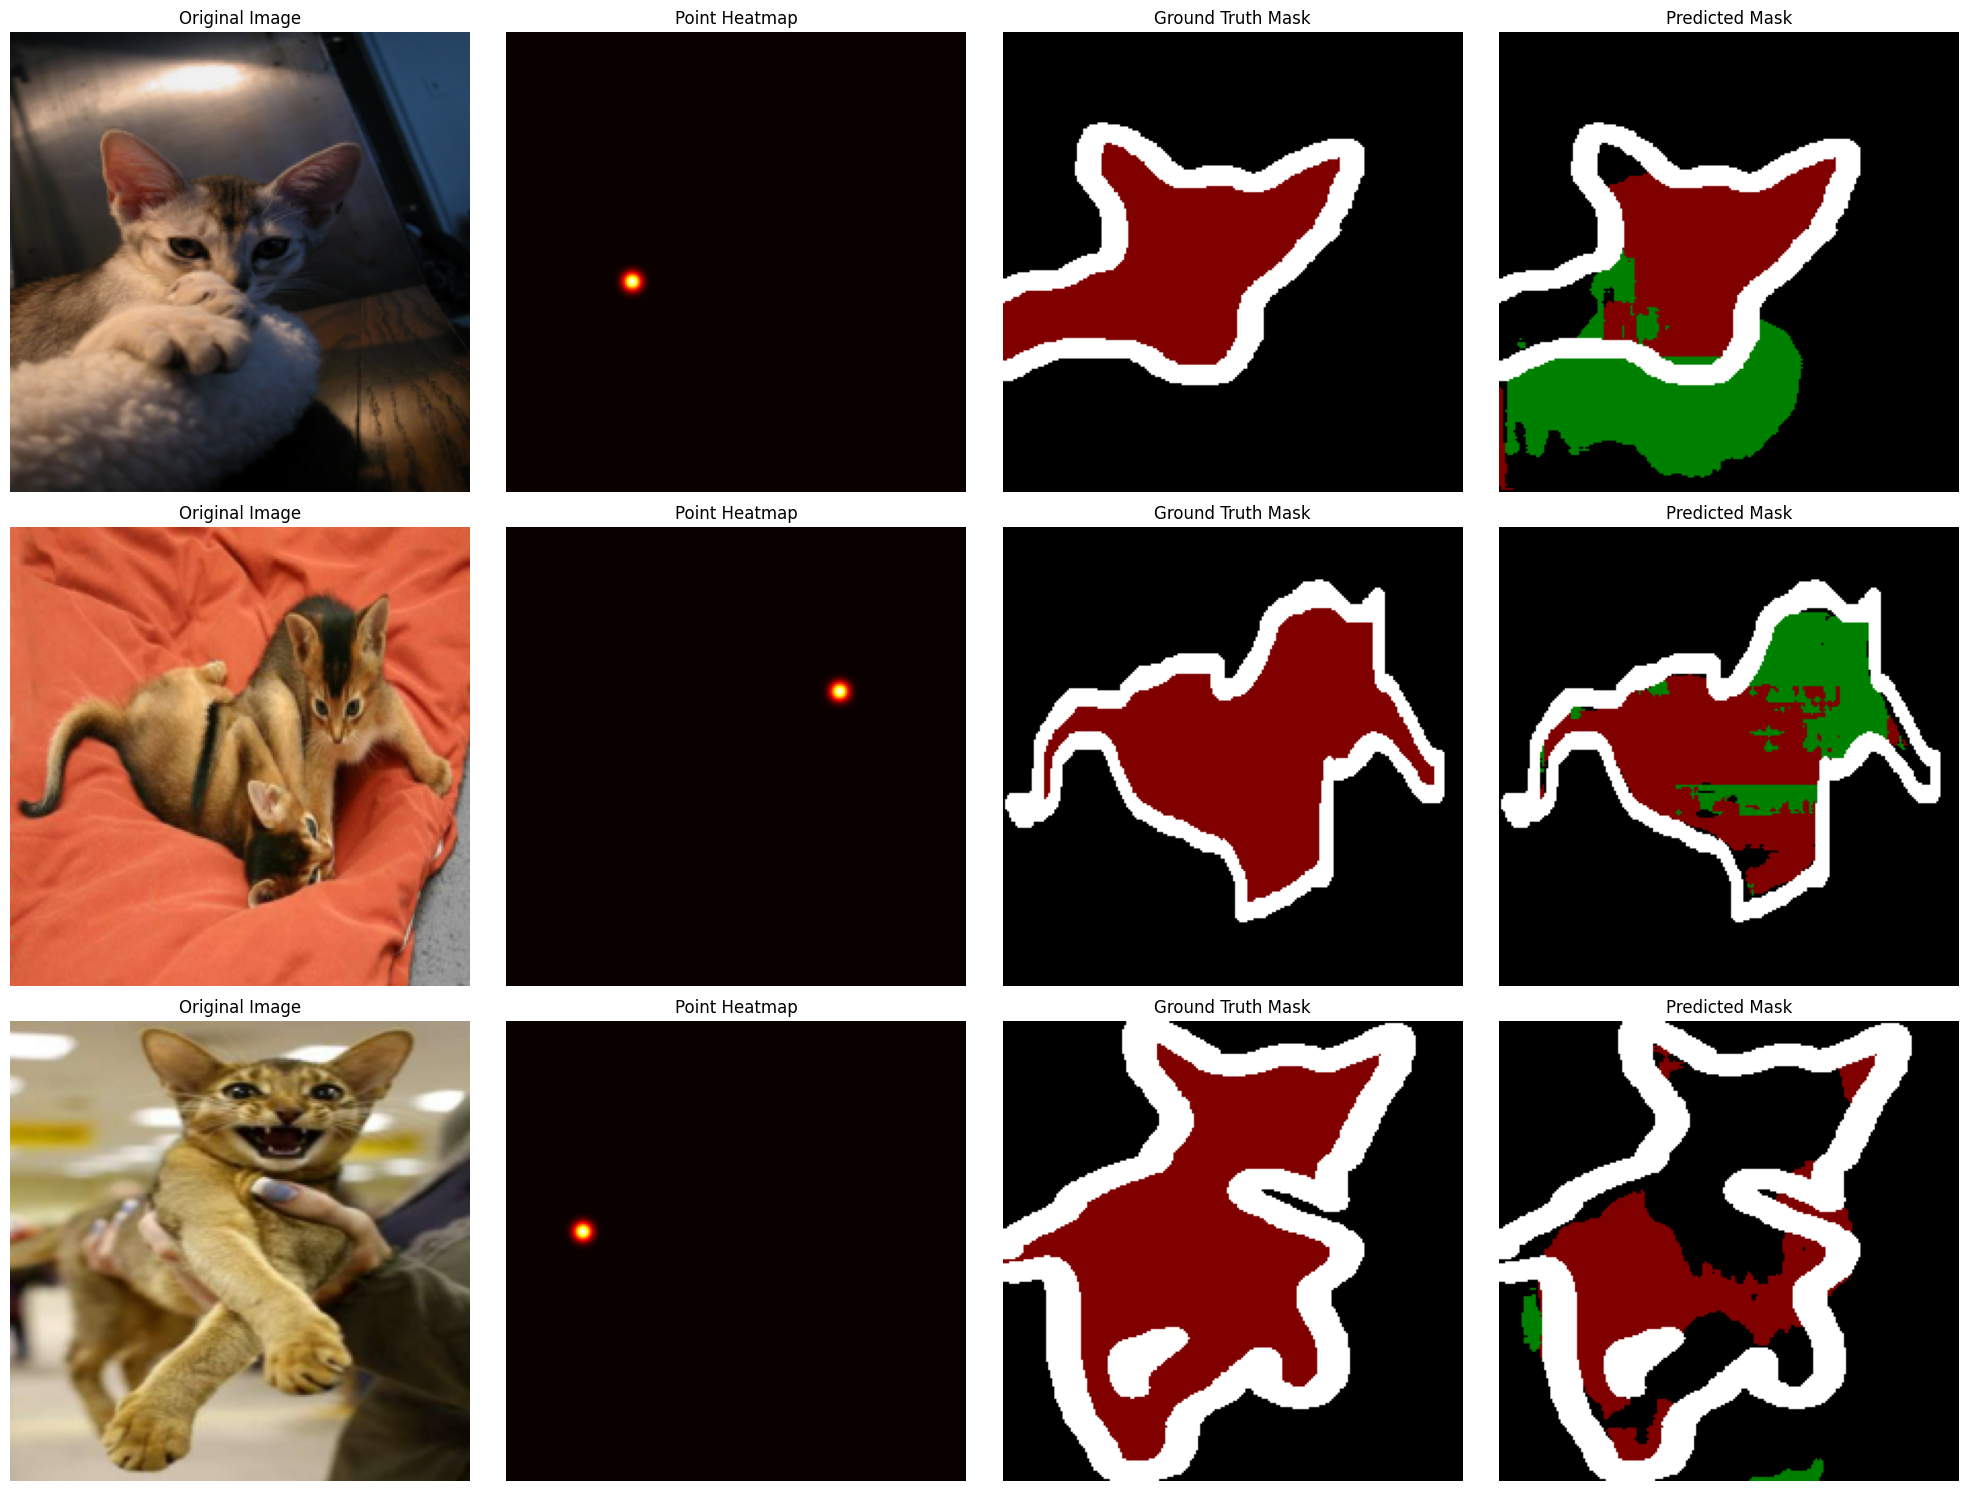

In [8]:
# Create model instance
model = PointPromptedUNet()
checkpoint = torch.load('runs/point_based_unet/loss_weighted_20epochs/point_prompted_unet_pet_segmentation_best.pt', 
                       map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Dataloader

# Visualize results on validation set
print("\nVisualizing U-Net results on validation set:")
visualize_point_based_unet_results(model, val_loader, device, num_samples=3)